## Context & Expectations 

The merlin models with fine grain budgets require to automagically redistribute moneys according to a changed funding (e.g. 'hair cut' or re-prioritization) of projects. Therefore an algorithm for apportioning is key to simulate different scenarios. The input should be limited to a few key facts for each project only.

In order to distribute an amount to different budgets and deal with project importance as well as different money reqirements, three characteristic properties are captured for each budget:

* the minimum amount `min` required to fund this project
* the optimal amount `opt` desired to fund this project
* the weight/priority of funding allocation


In [1]:
from collections import namedtuple
budget_item = namedtuple('budget_item', ['min', 'opt', 'weight'])

The expectations to the apportioning algorithm are:

* with 0 funding there is 0 allocation to each project (trivial!)
* with just enough money (i.e. sum of minimal amount) each project should get the minimal amount
* the same with the optimal amount of money
* if the total amount is increased, no project should get less funding
* the total amount will be apportioned, no non-allocated money

Implied by this: no project will get more funding before all projects reached the next funding milestone (min or opt).

With higher priority the projects should be fully funded, but tradeoffs in favour of inexpensive projects should be allowed.

## Implemenation

In [2]:
def apportioning(budget_sum, budgets):
    assert all(0<=b.min<=b.opt for b in budgets)
    assert all(b.weight>0 for b in budgets)
    
    min_sum = sum(b.min for b in budgets)
    opt_sum = sum(b.opt for b in budgets)
    # define the base apportioning and the next 'mile-stone'
    if budget_sum < min_sum:
        #print('not enough funding')
        apportion = [0.0]*len(budgets)
        apportion_max = [b.min for b in budgets]
    elif budget_sum < opt_sum:
        #print('just enough funding')
        apportion = [b.min for b in budgets]
        apportion_max = [b.opt for b in budgets]
    else:
        #print('sufficient funding')
        apportion = [b.opt for b in budgets]
        apportion_max = [None for b in budgets]

    leftover = budget_sum - sum(apportion)
    while leftover > 0.0:
        # redistribute left-over money till nothing left
        
        # the weights consider the importance (measured as
        # weight) as well as the size of the project
        # (measured in budget required)
        leftover_weights = [(a_max-a)*b.weight
                            if a_max is not None else b.weight
                            for a_max, a, b in zip(apportion_max,
                                                   apportion,
                                                   budgets)]
        # start with the largest weights, eliminate the 0 weights
        idx = [i for i in sorted(range(len(leftover_weights)),
                                 key=lambda j: leftover_weights[j],
                                 reverse=True)
               if leftover_weights[i]>0.0]
        
        if len(idx)==1:
            # trivial case!
            apportion[idx[0]] += leftover
        elif len(idx)==0:
            # all moneys should be already distributed
            assert False, "shouldn't be here"
        else:
            weight_sum = sum(leftover_weights[i] for i in idx)
            for i in idx:
                apportion[i] += leftover_weights[i]/weight_sum*leftover
                if apportion_max[i] is not None:
                    # observe upper limit
                    apportion[i] = min(apportion[i], apportion_max[i])
        # recalculate the left-overs
        leftover = budget_sum - sum(apportion)
    # done, return the result as list in same order as budget items
    return apportion

## Example

An example budget:

In [3]:
budgets = [budget_item(2, 2.5, 2), # blue
           budget_item(1, 2, 1),   # green
           budget_item(0.5, 1, 8)] # red

Three budgets are defined (numbers in brackets are: `min`, `opt` and `weight`). The funding milestones are: 3.5 for minimal funding and 5.5 for optimal funding. It is expected that the third (red) budget gets the funding with priority.

Populating the interactive namespace from numpy and matplotlib


/opt/webstack/lib/python3.5/site-packages/ipython-4.2.0-py3.5.egg/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/opt/webstack/lib/python3.5/site-packages/ipython-4.2.0-py3.5.egg/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


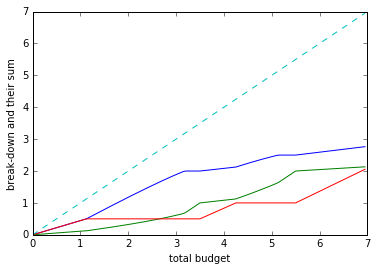

In [4]:
#import pylab
%pylab inline
import mpld3
mpld3.enable_notebook()
f = pylab.arange(0, 7, 0.05)
fff = [apportioning(ff, budgets) for ff in f]
for b in zip(*fff):
    pylab.plot(f, b)
pylab.plot(f, [sum(ff) for ff in fff], '--')
pylab.xlabel('total budget')
pylab.ylabel('break-down and their sum')
pylab.show()

The example above shows the apportioning for increasing budgets:

* The budget is used completely as the broken line is straight.
* The minimum and the optimium budget milestones are achived at 3.5 and 5.5.
* The weight=8 budget (red) gets the moneys required first (it is the one with the least expenses as well).
* The weight of the high priority budget (red) weighs as much as the large expenses of the first project (blue), so initially they get equal moneys allocated.
* The most expensive budget (blue) reaches the funding mile stones second.
* When the red and the blue line reach the funding mile stones, all extra moneys go to green (the lowest weighted budget).

## Hair-cut: Applying apportioning to merlin services

For a given `simulation` all budgets are modified (typically decreased) by a schedule defined by the apportioning algorithm above and a user input, the 'hair-cut' percentage. 

Different assumptions can be made to retrieve the parameters for the apportioning algorithm.

First approach:

* The budgetal figures (i.e. the `amount` ProcessProperty of each of the BudgetProcesses) suggest the optimal budget.
* The user provides then the weights, they default to 1.
* Minimum amounts can be introduced to prevent certain services to be cut too much.

Another approach:

* set minimal and optimal budgets to 0 and
* the weight to the amount allocated initially.

And another one:

* utilize the min and default field in the ProcessProperty
* the weight is set to 1.

And another idea:

* use the services' budgetal surplusses to adjust the weights 


### Implementation

Quite a bit of code can be copied/recycled from the impact calculations.

To do a hair-cut at a specific time the simulation is run to this point. Instead of getting the value/default the values are retrieved from telemetry output. This will be implemented later.

The persistent and unique identification of elements from the same model, but different simulations might become difficult. (e.g. when projects modify the simulation such that they can't be reset).

In [5]:
# necessary imports
python_merlin_dir="/var/jupyter-notebook/python-merlin"
import sys
if python_merlin_dir not in sys.path:
    sys.path.append(python_merlin_dir)
%reload_ext pymerlin.merlin
%reload_ext pymerlin.processes
from pymerlin import merlin, processes
%reload_ext examples.DIAServicesModel
%reload_ext examples.RecordStorageFacility
%reload_ext examples.passportPrinter
from examples import DIAServicesModel, RecordStorageFacility, passportPrinter

In [6]:
# that's a legacy model from April 2016
modelFactoryFunction=RecordStorageFacility.manyBudgetModel
# that is the 'canonical' model
modelFactoryFunction=DIAServicesModel.createRecordStorage

In [7]:
s=modelFactoryFunction()
# find all budgets which are source entities
# store tuples budget (entity, original value)
merlin_budgets=[]
for se in s.source_entities:
    seps=se.get_processes()
    assert len(seps)==1
    sep=seps[0]
    if isinstance(sep, processes.BudgetProcess):
        sepp=sep.get_prop("amount")
        # hope they are unique by name, might break in future...
        assert se.name not in merlin_budgets, 'budget enitity name %s not unique'%se.name
        print(se.name, sepp.get_value(), sepp.default, sepp.min_val, sepp.max_val)
        merlin_budgets.append((se, sepp.get_value()))

merlin_budgets_sum=sum(s[1] for s in merlin_budgets)

Budgeted – Staff Expenses 400000000 400000000 None None
Budgeted – Rent Expenses 400000000 400000000 None None
Budgeted – Other Expenses 400000000 400000000 None None


In [8]:
# here are the user parameters defined
# tuples are: (weight, minimum)
user_input={'Budgeted – Other Expenses': (1, 0),
            'Budgeted – Rent Expenses': (0.8, 0),
            'Budgeted – Staff Expenses': (1, 0)}

In [9]:
# create the apportioning from the user input and the model values
apportioning_budgets=[]
for se, val in merlin_budgets:
    budgetName=se.name
    weight, minimum = user_input[budgetName]
    apportioning_budgets.append(budget_item(min=minimum,
                                            opt=val,
                                            weight=weight))
# and calculate the budgets for hair cuts between 0% and 50%
f = pylab.arange(0.01, 1, 0.01)
fff = [apportioning(ff*merlin_budgets_sum, apportioning_budgets) for ff in f]

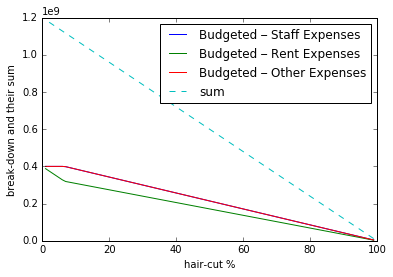

In [10]:
# plot the apportioning results
for b, (se, _) in zip(zip(*fff), merlin_budgets):
    pylab.plot((1-f)*100, b, label=se.name)
pylab.plot((1-f)*100, [sum(ff) for ff in fff], '--', label='sum')
pylab.legend(loc='upper right')
pylab.xlabel('hair-cut %')
pylab.ylabel('break-down and their sum')
pylab.show();

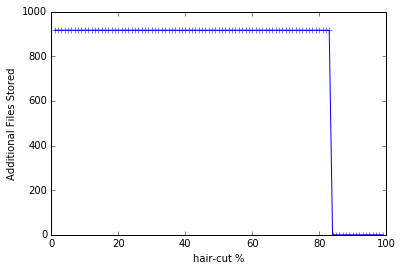

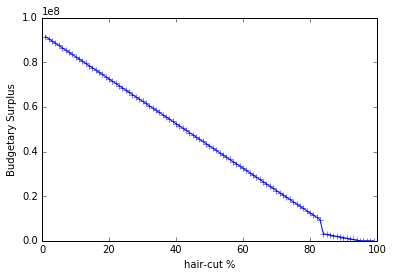

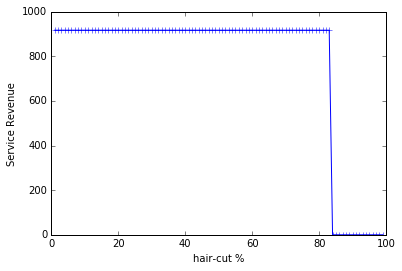

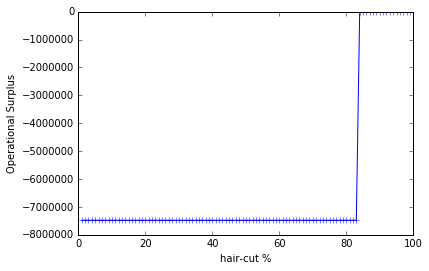

In [11]:
# and calculate the average outputs over one year for each
from collections import defaultdict
outputvals=defaultdict(list)
for impactvals in fff:
    # update budgets
    for (se, _), val in zip(merlin_budgets, impactvals):
        # assume, only one process per enitity
        sep=se.get_processes()[0]
        sep.get_prop('amount').set_value(val)
    # rely on proper resetting in run
    s.run(start=1, end=12)
    outs = s.get_sim_telemetry()
    for out in outs[:-1]:
        if out['type']=="Output":
            outputvals[out['name']].append(sum(out["data"]["value"])/
                                           len(out["data"]["value"]))
# and plot them as well
for k,v in outputvals.items():
    pylab.xlabel('hair-cut %')
    pylab.ylabel(k)
    pylab.plot(100*(1-f), v, '+-')
    pylab.show()